In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")
data_path = os.path.join(project_root, "data\\raw")
file_path = os.path.join(data_path, "Desempleo.xls")


if src_path not in sys.path:
    sys.path.append(src_path)

from utils import table_kpss, table_adf
from plots import plot_acf_sample, plot_pacf_sample, plot_acf_theoretical, plot_pacf_theoretical

FIG_PATH = os.path.join(project_root, "results", "figures")

os.makedirs(FIG_PATH, exist_ok=True)

np.random.seed(4242)


In [ ]:
df = pd.read_excel(file_path, header=None) 

df = df.iloc[4:191, 0:2]  

df.reset_index(drop=True, inplace=True)

df.columns = ["Date", "Value"]

df.head()


,Date,Value
0,2010-03-01 00:00:00,9.227598
1,2010-04-01 00:00:00,8.836054
2,2010-05-01 00:00:00,9.087731
3,2010-06-01 00:00:00,8.656064
4,2010-07-01 00:00:00,8.511179


In [32]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

df.set_index("Date", inplace=True)

X = df["Value"]
X


Date
2010-03-01    9.227598
2010-04-01    8.836054
2010-05-01    9.087731
2010-06-01    8.656064
2010-07-01    8.511179
                ...   
2025-05-01    8.943014
2025-06-01    8.892661
2025-07-01    8.698979
2025-08-01    8.561129
2025-09-01    8.528949
Name: Value, Length: 187, dtype: object

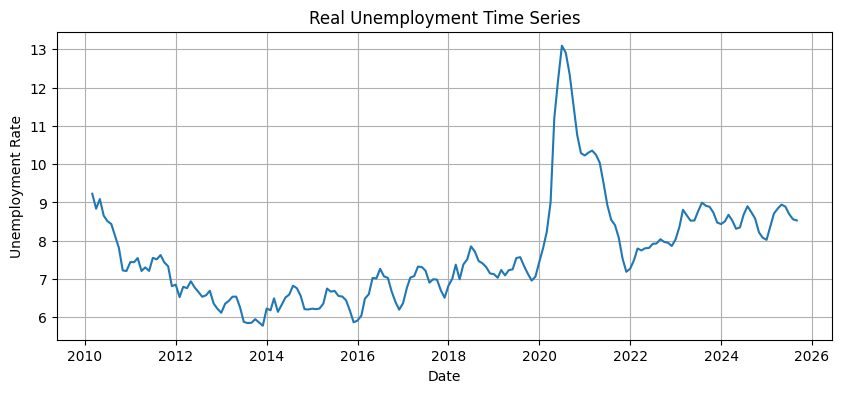

In [35]:
plt.figure(figsize=(10,4))
plt.plot(X)
plt.title("Real Unemployment Time Series")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate")
plt.grid(True)
plt.show()

In [36]:

df_adf  = table_adf(X, autolag="AIC")
df_kpss = table_kpss(X, regression='c', nlags='auto')

print("\n=== Augmented Dickey-Fuller Test (ADF) ===")
display(df_adf)

print("\n=== KPSS Test ===")
display(df_kpss)


=== Augmented Dickey-Fuller Test (ADF) ===


,Statistic,p-value,Lags used,N obs,Crit (1%),Crit (5%),Crit (10%)
0,-2.269538,0.181981,10,176,-3.468062,-2.878106,-2.575602



=== KPSS Test ===


,Statistic,p-value,Lags used,Crit (10%),Crit (5%),Crit (2.5%),Crit (1%)
0,0.828083,0.01,9,0.347,0.463,0.574,0.739


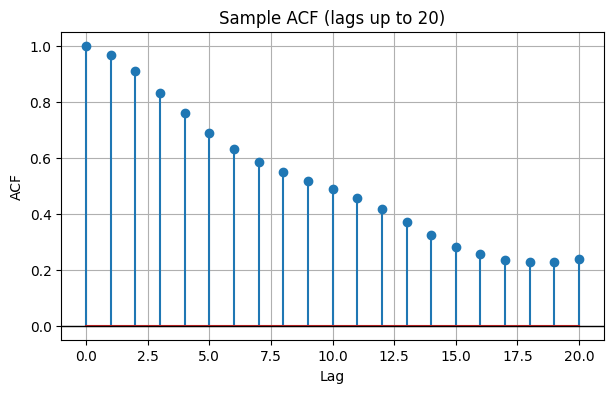

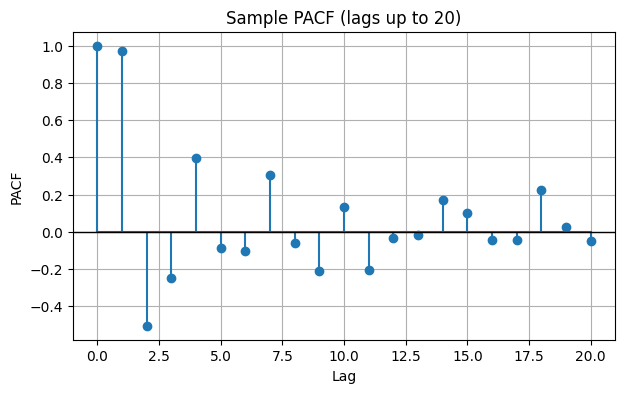

In [37]:
plot_acf_sample(X, lags=20)
plot_pacf_sample(X, lags=20)